<a href="https://colab.research.google.com/github/aacelas/MetNumUN2024II/blob/main/strategy_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [ ]:
# loading S&P 500 stock data, for a specific set of assets chosen randomly looking for diversification and
# variability, checking only that when displaying the features, none have empty fields, from June 1st, 2005,
# onwards.

data = qndata.stocks.load_spx_data(min_date="2005-06-01",
                                   assets=[ 'NAS:AAPL', 'NYS:DELL', 'NAS:ACGL', 'NAS:ADBE', 'NAS:ADI', 'NAS:ADP',
 'NAS:ADSK', 'NAS:AEP', 'NYS:BSX', 'NYS:BWA', 'NYS:BX', 'NAS:AMAT', 'NAS:AMD', 'NYS:MET', 'NYS:MGM', 'NYS:UBER', 'NYS:UDR',
 'NAS:AMGN', 'NAS:AMZN', 'NAS:ANSS'])

fetched chunk 1/1 0s
Data loaded 0s


In [ ]:
# added volume, On-Balance Volume (OBV), Average Directional Index (ADX),
# 50-day moving average (ma_50), 200-day moving average (ma_200) and 50-day volatility as new features.
# Volume can provide insights into the strength of price movements.
# OBV is a momentum indicator that uses volume flow to predict changes in stock price.
# ADX helps determine if there's a strong trend in either direction.
# 50-day moving average (ma_50) is commonly used in financial analysis to represent the short-term trend
# 200-day moving average (ma_200) gives a broader perspective on the overall price direction
# 50-day volatility is commonly used to represent the price fluctuation

def adx(high, low, close, period=14):
    """Calculate ADX (Average Directional Index)"""
    # Calculate +DM and -DM
    high_diff = high - qnta.shift(high, 1)
    low_diff = qnta.shift(low, 1) - low

    plus_dm = xr.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = xr.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)

    # Calculate TR
    tr = qnta.tr(high, low, close)

    # Calculate +DI and -DI
    plus_di = 100 * qnta.ema(plus_dm, period) / qnta.ema(tr, period)
    minus_di = 100 * qnta.ema(minus_dm, period) / qnta.ema(tr, period)

    # Calculate DX and ADX
    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = qnta.ema(dx, period)

    return adx

def get_features(data):
    """Builds the features used for learning"""

    # Existing features
    close_price = data.sel(field="close")

    trend = qnta.roc(qnta.lwma(close_price, 60), 1)
    trend = trend.assign_coords(field="trend")

    macd_line, signal_line, hist = qnta.macd(close_price)
    signal_line = signal_line.assign_coords(field="macd")

    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), close_price)
    volatility = volatility / close_price
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), close_price, 14)
    d = d.assign_coords(field="stochastic_d")

    rsi = qnta.rsi(close_price)
    rsi = rsi.assign_coords(field="rsi")

    price = np.log(close_price.ffill("time").bfill("time").fillna(0))
    price = price.assign_coords(field="price")

    # New features
    volume = np.log(data.sel(field="vol").ffill("time").bfill("time").fillna(0))
    volume = volume.assign_coords(field="volume")

    obv = qnta.obv(close_price, data.sel(field="vol"))
    obv = obv.assign_coords(field="obv")

    adx_values = adx(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    Adx = xr.DataArray(adx_values, dims=volume.dims, coords=volume.coords).assign_coords(field="adx")

    ma_50 = close_price.rolling(time=50).mean().expand_dims('field').assign_coords(field=['ma_50'])
    ma_200 = close_price.rolling(time=200).mean().expand_dims('field').assign_coords(field=['ma_200'])
    volatility50 = close_price.rolling(time=50).std().expand_dims('field').assign_coords(field=['volatility50'])

    # Concatenar todos los features
    result = xr.concat(
        [trend, signal_line, volatility, d, rsi, price, volume, obv, Adx, ma_50, ma_200, volatility50],
        dim="field"
    )

    return result.transpose("time", "field", "asset")

In [ ]:
#funcion utilizada para los valores obtenidos que se muestran en pantalla

def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [ ]:
# def get_target_classes(data):

#     price_current = qnta.change(data.sel(field='close'))/(data.sel(field='close'))
#     price_future = price_current.shift(time=-1)

#     move = 0.005

#     class_positive = 1 # prices goes up more than move*100%
#     class_neutral = 0 # prices does not move more than move*100%
#     class_negative = -1 # price goes down more than move*100%

#     target_price = xr.where(price_future < -move, class_negative, price_future)
#     target_price = xr.where(target_price > move, class_positive, target_price)
#     target_price = xr.where(abs(target_price) !=1 , class_neutral, target_price)


#     return target_price

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AMAT,NAS:AMD,NAS:AMGN,NAS:AMZN,NAS:ANSS,NYS:BSX,NYS:BWA,NYS:BX,NYS:DELL,NYS:MET,NYS:MGM,NYS:UBER,NYS:UDR
time,,,,,,,,,,,,,,,,,,,,
2005-06-01,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
2005-06-02,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0
2005-06-03,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1
2005-06-06,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,1
2005-06-07,1,1,0,1,0,0,1,1,1,0,0,0,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,0,1,1,1,1,0,1,0,1,1,0,0,0,1,1,0,1,1,0,1
2025-01-13,0,1,1,1,1,1,0,1,0,0,0,1,1,1,1,0,1,1,0,1
2025-01-14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0


In [ ]:
# Random Forest is chosen because:
# 1. It can handle non-linear relationships in the data.
# 2. It's less prone to overfitting compared to single decision trees.
# 3. It can handle high-dimensional data well.
# 4. It provides feature importance, which can be useful for understanding which factors are most predictive.

def get_model():
    # Initialize the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    return model

In [ ]:
## Liquidity filter and clean

liquid_assets = data.sel(field='is_liquid')
weights = weights * liquid_assets
weights = qnout.clean(weights, data, "stocks_s&p500")

Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights)
sharpe

7.85508868482885

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [ ]:
statistics = qnstats.calc_stat(data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-10,3.078796e+08,-0.015497,0.218636,-0.015497,-0.321041,7.832429,1.712448,1.0,20.0,0.592976,3.249046
2025-01-13,3.114298e+08,0.011531,0.218620,-0.004144,-0.321041,7.837743,1.713487,1.0,20.0,0.593005,3.248792
2025-01-14,3.140421e+08,0.008388,0.218600,0.000000,-0.321041,7.841241,1.714096,1.0,20.0,0.592978,3.248753
2025-01-15,3.193914e+08,0.017034,0.218598,0.000000,-0.321041,7.849523,1.715886,1.0,20.0,0.592956,3.248781
2025-01-16,3.232159e+08,0.011975,0.218583,0.000000,-0.321041,7.855089,1.716987,1.0,20.0,0.592933,3.248983


time,2025-01-16
field,
sharpe_ratio,7.855089


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


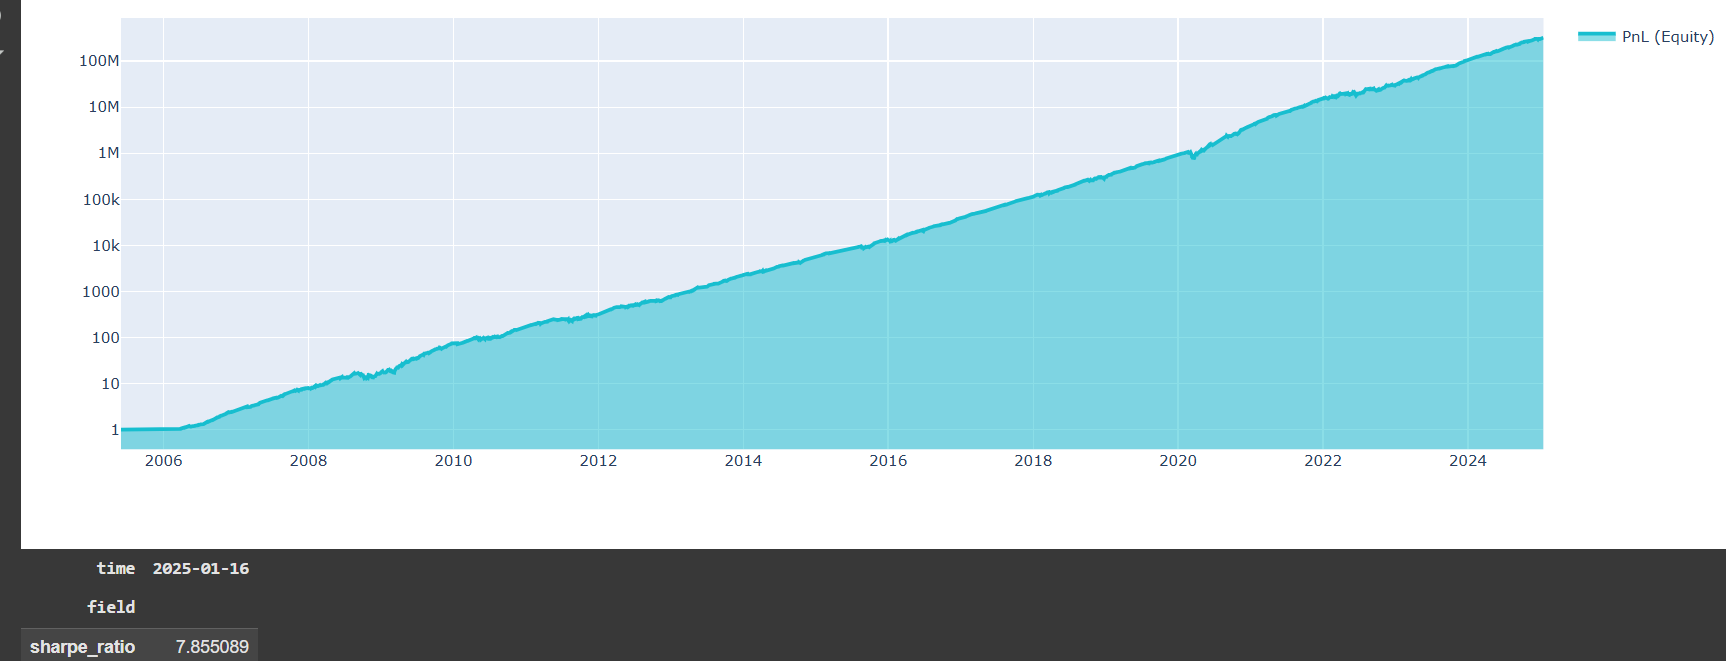

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time",  how="any")
        features_cur = features_all.sel(asset=asset_name).dropna("time",  how="any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                print(f"Not enough data to train the model for: {asset_name}. Skipped")
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except Exception as e:
            logging.exception("model training failed for: %s", asset_name)

    return models

In [ ]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time",  how="any")

            if len(features_cur.time) < 1:
                print(f"No features available for: {asset_name}. Skipped")
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except Exception as e:
                logging.exception("model training failed for: %s", asset_name)

    liquid_assets = data.sel(field='is_liquid')
    weights = weights * liquid_assets
    weights = qnout.clean(weights, data, "stocks_s&p500")

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

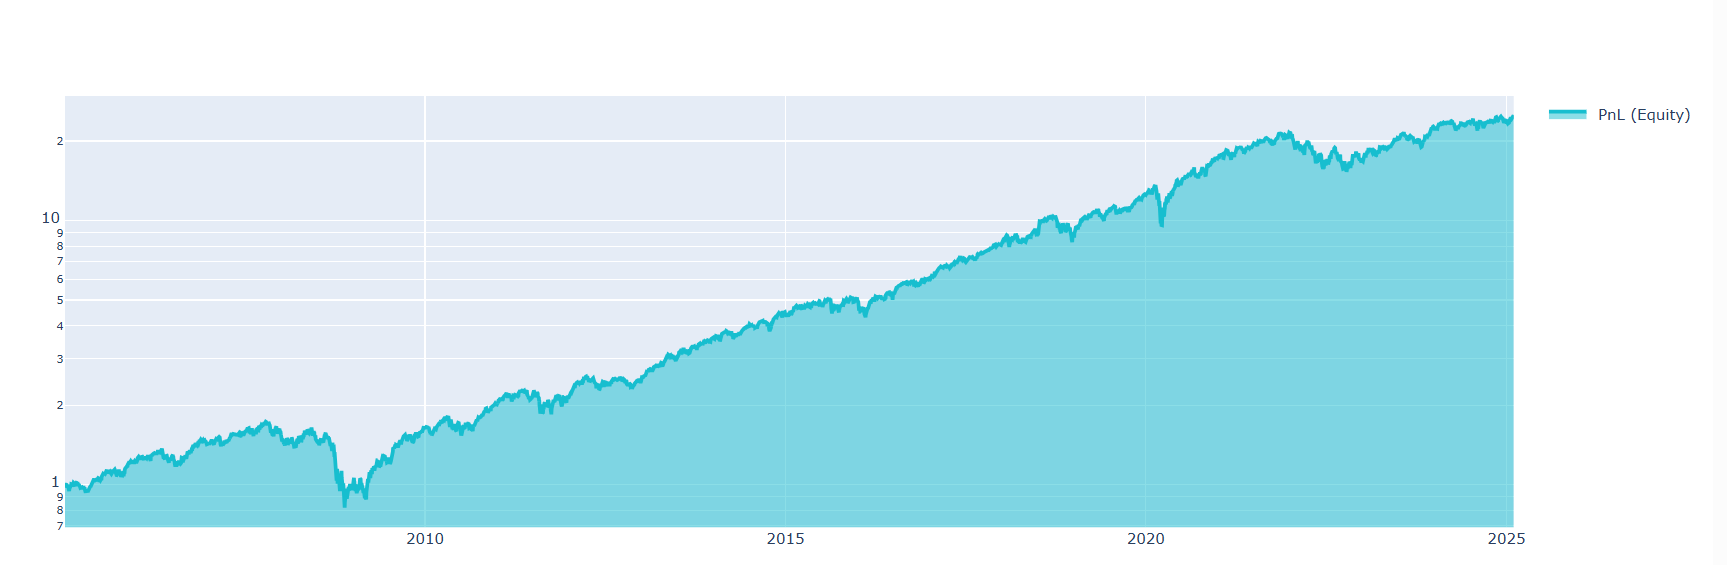

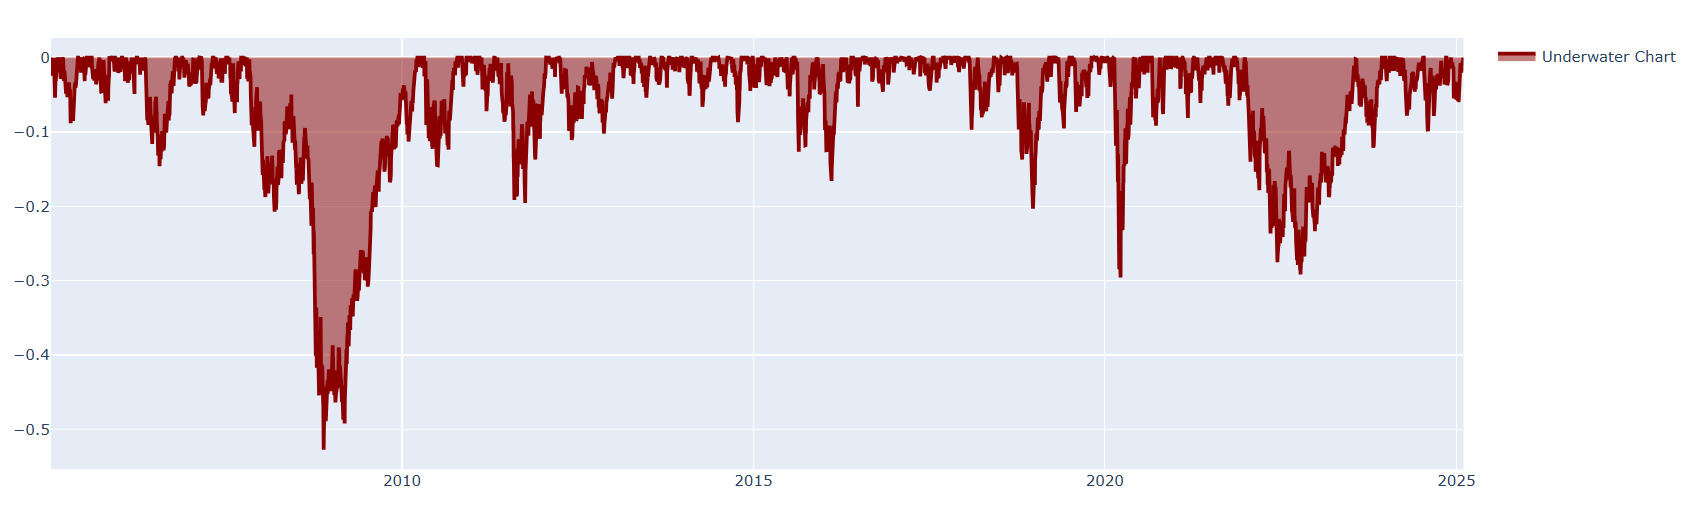

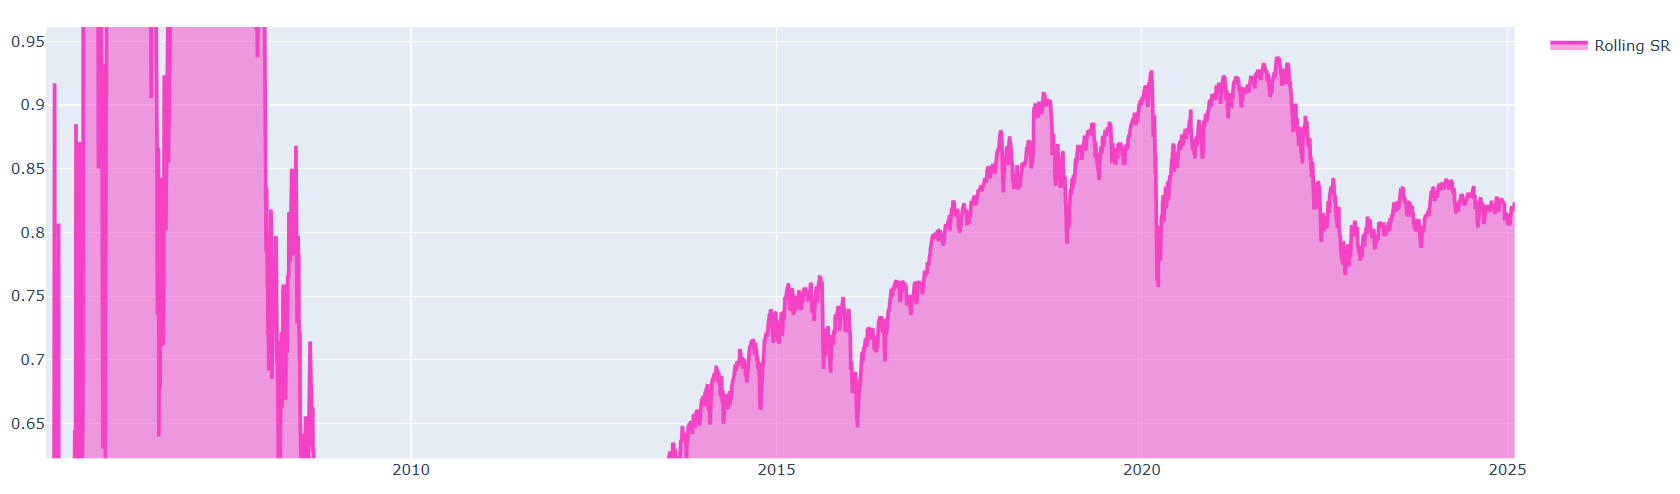

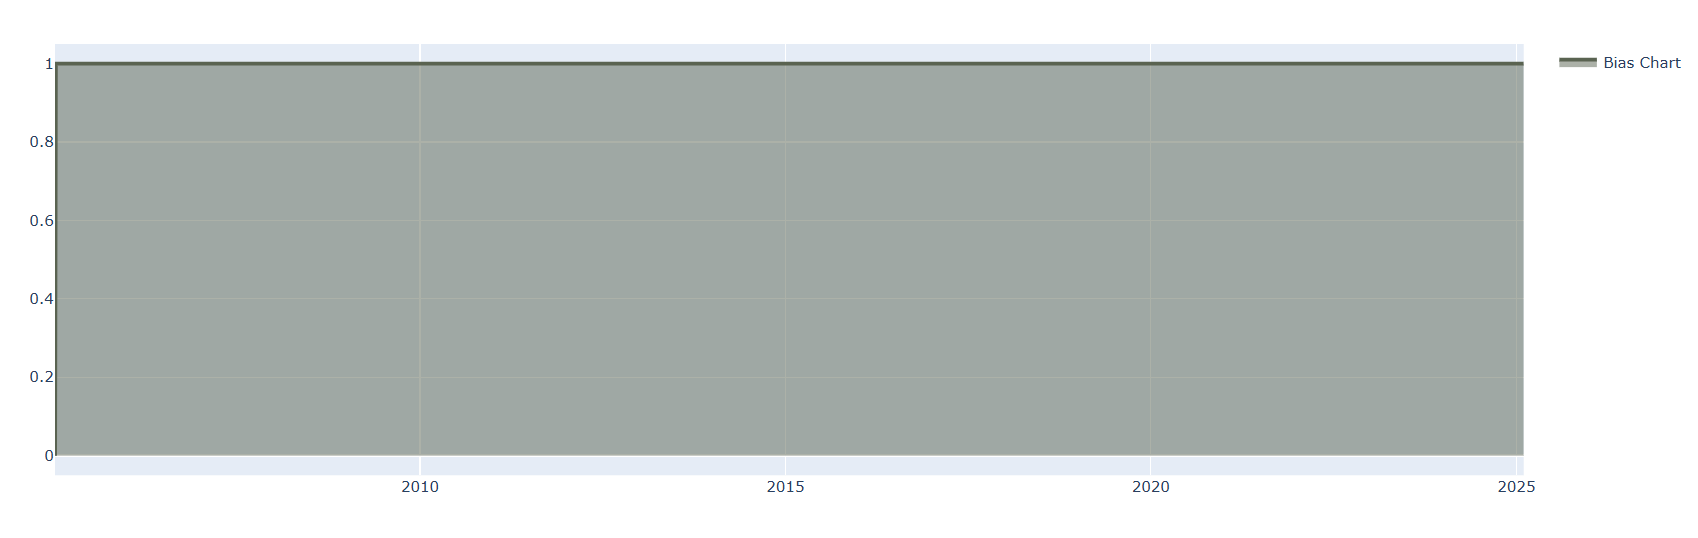

Se obtuvo

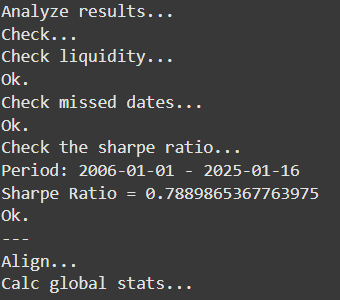

The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!